In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

import re
import string
from wordcloud import WordCloud
from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# 1 for spam and 0 form ham
data = pd.read_csv('/content/drive/MyDrive/Machine_learning_projects/email_spam_classification/emails.csv')
data.sample(5)

,label,text
39634,1,memo to ensure that you r weekly forecasts are...
62560,1,oem software means no cd dvd no packing case n...
33786,1,save up to 80 % on popular meds !\n* * * great...
7567,0,crabtree evelyn email exclusives if you are no...
2639,0,on tue escapenumber escapenumber escapenumber ...


In [3]:
data['label'].value_counts()

,count
label,
1,43910
0,39538


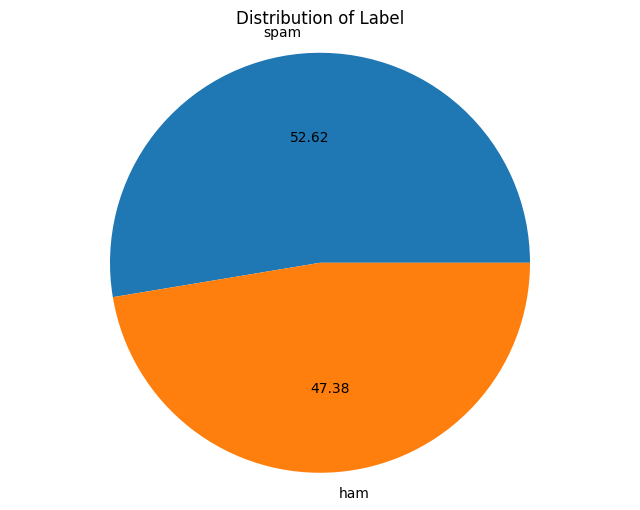

In [4]:
str_label = data['label'].map({0 : 'ham' , 1 : 'spam'})

plt.figure(figsize=(8,6))
plt.pie(str_label.value_counts(), labels=str_label.value_counts().index, autopct='%0.2f')
plt.title('Distribution of Label')
plt.axis('equal')
plt.show()

In [5]:
# avarage length of the emails
data['length'] = data['text'].apply(len)
data['num_words'] = data['text'].apply(word_tokenize).apply(len)
data['num_stenence'] = data['text'].apply(sent_tokenize).apply(len)
data.head()


,label,text,length,num_words,num_stenence
0,1,ounce feather bowl hummingbird opec moment ala...,148,20,1
1,1,wulvob get your medircations online qnb ikud v...,808,104,1
2,0,computer connection from cnn com wednesday es...,2235,338,1
3,1,university degree obtain a prosperous future m...,592,76,1
4,0,thanks for all your answers guys i know i shou...,1362,223,1


In [6]:
avg_length_spam = data[data['label']== 1 ]['length'].mean()
avg_length_ham = data[data['label']== 0 ]['length'].mean()

avg_word_spam = data[data['label']== 1 ]['num_words'].mean()
avg_word_ham = data[data['label']== 0 ]['num_words'].mean()

avg_sentence_spam = data[data['label']== 1 ]['num_stenence'].mean()
avg_sentence_ham = data[data['label']== 0 ]['num_stenence'].mean()

print(f'Average length of spam emails: {avg_length_spam:.2f}')
print(f'Average length of ham emails: {avg_length_ham:.2f}')

print(f'Average number of words in spam emails: {avg_word_spam:.2f}')
print(f'Average number of words in ham emails: {avg_word_ham:.2f}')

print(f'Average number of sentences in spam emails: {avg_sentence_spam:.2f}')
print(f'Average number of sentences in ham emails: {avg_sentence_ham:.2f}')

Average length of spam emails: 1249.89
Average length of ham emails: 2121.69
Average number of words in spam emails: 210.61
Average number of words in ham emails: 367.66
Average number of sentences in spam emails: 6.45
Average number of sentences in ham emails: 8.14


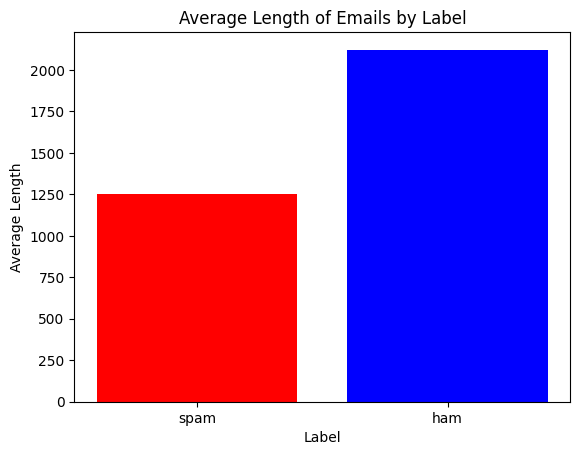

In [7]:
plt.bar(['spam', 'ham'], [avg_length_spam, avg_length_ham], color=['red','blue'])
plt.title('Average Length of Emails by Label')
plt.xlabel('Label')
plt.ylabel('Average Length')
plt.show()

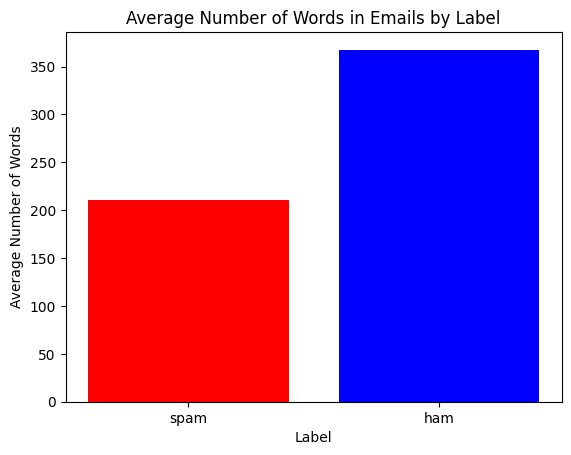

In [8]:
plt.bar(['spam','ham'], [avg_word_spam, avg_word_ham], color=['red','blue'])
plt.title('Average Number of Words in Emails by Label')
plt.xlabel('Label')
plt.ylabel('Average Number of Words')
plt.show()

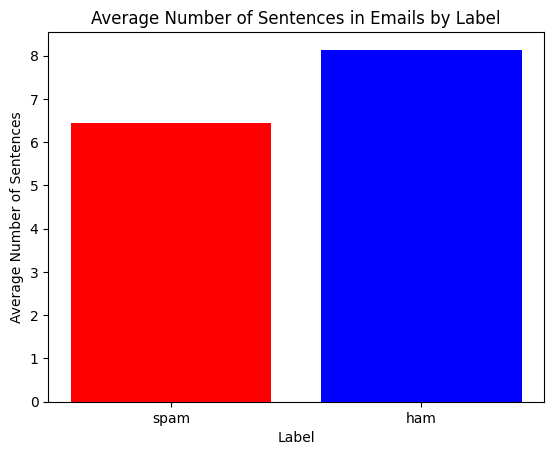

In [9]:
plt.bar(['spam','ham'], [avg_sentence_spam, avg_sentence_ham], color=['red','blue'])
plt.title('Average Number of Sentences in Emails by Label')
plt.xlabel('Label')
plt.ylabel('Average Number of Sentences')
plt.show()

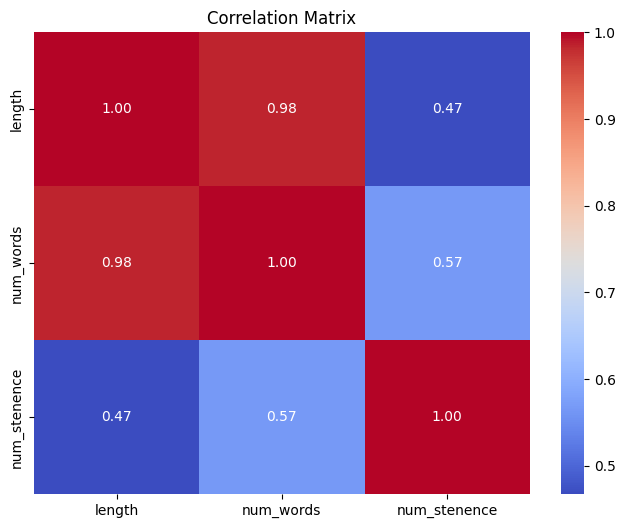

In [10]:
correlation_matrix = data[['length','num_words','num_stenence']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

The correlation matrix indicates strong positive correlations between email length and the number of words (0.98) as well as between the number of words and the number of sentences (0.57). This suggests that longer emails tend to have more words, and emails with more words tend to have more sentences. However, the correlation between email length and the number of sentences is weaker (0.47). This implies that while longer emails may have more sentences, the relationship is not as strong as with the number of words. Understanding these relationships helps us grasp how different features contribute to the overall structure and content of emails, aiding in spam classification.

#Data Preprocessing

In [11]:
data['cleaned_text'] = data['text'].str.lower()
data

,label,text,length,num_words,num_stenence,cleaned_text
0,1,ounce feather bowl hummingbird opec moment ala...,148,20,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...,808,104,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...,2235,338,1,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...,592,76,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...,1362,223,1,thanks for all your answers guys i know i shou...
...,...,...,...,...,...,...
83443,0,hi given a date how do i get the last date of ...,2589,344,1,hi given a date how do i get the last date of ...
83444,1,now you can order software on cd or download i...,616,118,25,now you can order software on cd or download i...
83445,1,dear valued member canadianpharmacy provides a...,534,76,1,dear valued member canadianpharmacy provides a...
83446,0,subscribe change profile contact us long term ...,2113,277,1,subscribe change profile contact us long term ...


In [12]:
# word tokanization
data['cleaned_text'] = data['cleaned_text'].apply(word_tokenize)
data

,label,text,length,num_words,num_stenence,cleaned_text
0,1,ounce feather bowl hummingbird opec moment ala...,148,20,1,"[ounce, feather, bowl, hummingbird, opec, mome..."
1,1,wulvob get your medircations online qnb ikud v...,808,104,1,"[wulvob, get, your, medircations, online, qnb,..."
2,0,computer connection from cnn com wednesday es...,2235,338,1,"[computer, connection, from, cnn, com, wednesd..."
3,1,university degree obtain a prosperous future m...,592,76,1,"[university, degree, obtain, a, prosperous, fu..."
4,0,thanks for all your answers guys i know i shou...,1362,223,1,"[thanks, for, all, your, answers, guys, i, kno..."
...,...,...,...,...,...,...
83443,0,hi given a date how do i get the last date of ...,2589,344,1,"[hi, given, a, date, how, do, i, get, the, las..."
83444,1,now you can order software on cd or download i...,616,118,25,"[now, you, can, order, software, on, cd, or, d..."
83445,1,dear valued member canadianpharmacy provides a...,534,76,1,"[dear, valued, member, canadianpharmacy, provi..."
83446,0,subscribe change profile contact us long term ...,2113,277,1,"[subscribe, change, profile, contact, us, long..."


In [13]:
# remove special characters
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in x])
data

,label,text,length,num_words,num_stenence,cleaned_text
0,1,ounce feather bowl hummingbird opec moment ala...,148,20,1,"[ounce, feather, bowl, hummingbird, opec, mome..."
1,1,wulvob get your medircations online qnb ikud v...,808,104,1,"[wulvob, get, your, medircations, online, qnb,..."
2,0,computer connection from cnn com wednesday es...,2235,338,1,"[computer, connection, from, cnn, com, wednesd..."
3,1,university degree obtain a prosperous future m...,592,76,1,"[university, degree, obtain, a, prosperous, fu..."
4,0,thanks for all your answers guys i know i shou...,1362,223,1,"[thanks, for, all, your, answers, guys, i, kno..."
...,...,...,...,...,...,...
83443,0,hi given a date how do i get the last date of ...,2589,344,1,"[hi, given, a, date, how, do, i, get, the, las..."
83444,1,now you can order software on cd or download i...,616,118,25,"[now, you, can, order, software, on, cd, or, d..."
83445,1,dear valued member canadianpharmacy provides a...,534,76,1,"[dear, valued, member, canadianpharmacy, provi..."
83446,0,subscribe change profile contact us long term ...,2113,277,1,"[subscribe, change, profile, contact, us, long..."


In [14]:
# remove stop words
stop_words = set(stopwords.words('english'))
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: [word for word in x if word not in stop_words])
data

,label,text,length,num_words,num_stenence,cleaned_text
0,1,ounce feather bowl hummingbird opec moment ala...,148,20,1,"[ounce, feather, bowl, hummingbird, opec, mome..."
1,1,wulvob get your medircations online qnb ikud v...,808,104,1,"[wulvob, get, medircations, online, qnb, ikud,..."
2,0,computer connection from cnn com wednesday es...,2235,338,1,"[computer, connection, cnn, com, wednesday, es..."
3,1,university degree obtain a prosperous future m...,592,76,1,"[university, degree, obtain, prosperous, futur..."
4,0,thanks for all your answers guys i know i shou...,1362,223,1,"[thanks, answers, guys, know, checked, rsync, ..."
...,...,...,...,...,...,...
83443,0,hi given a date how do i get the last date of ...,2589,344,1,"[hi, given, date, get, last, date, month, data..."
83444,1,now you can order software on cd or download i...,616,118,25,"[order, software, cd, download, site, immediat..."
83445,1,dear valued member canadianpharmacy provides a...,534,76,1,"[dear, valued, member, canadianpharmacy, provi..."
83446,0,subscribe change profile contact us long term ...,2113,277,1,"[subscribe, change, profile, contact, us, long..."


In [15]:
# lemmatization
lemmatizer = WordNetLemmatizer()
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
data

,label,text,length,num_words,num_stenence,cleaned_text
0,1,ounce feather bowl hummingbird opec moment ala...,148,20,1,"[ounce, feather, bowl, hummingbird, opec, mome..."
1,1,wulvob get your medircations online qnb ikud v...,808,104,1,"[wulvob, get, medircations, online, qnb, ikud,..."
2,0,computer connection from cnn com wednesday es...,2235,338,1,"[computer, connection, cnn, com, wednesday, es..."
3,1,university degree obtain a prosperous future m...,592,76,1,"[university, degree, obtain, prosperous, futur..."
4,0,thanks for all your answers guys i know i shou...,1362,223,1,"[thanks, answer, guy, know, checked, rsync, ma..."
...,...,...,...,...,...,...
83443,0,hi given a date how do i get the last date of ...,2589,344,1,"[hi, given, date, get, last, date, month, data..."
83444,1,now you can order software on cd or download i...,616,118,25,"[order, software, cd, download, site, immediat..."
83445,1,dear valued member canadianpharmacy provides a...,534,76,1,"[dear, valued, member, canadianpharmacy, provi..."
83446,0,subscribe change profile contact us long term ...,2113,277,1,"[subscribe, change, profile, contact, u, long,..."


In [16]:
# Convert the preprocessed text back to string
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: ' '.join(x))
data

,label,text,length,num_words,num_stenence,cleaned_text
0,1,ounce feather bowl hummingbird opec moment ala...,148,20,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...,808,104,1,wulvob get medircations online qnb ikud viagra...
2,0,computer connection from cnn com wednesday es...,2235,338,1,computer connection cnn com wednesday escapenu...
3,1,university degree obtain a prosperous future m...,592,76,1,university degree obtain prosperous future mon...
4,0,thanks for all your answers guys i know i shou...,1362,223,1,thanks answer guy know checked rsync manual wo...
...,...,...,...,...,...,...
83443,0,hi given a date how do i get the last date of ...,2589,344,1,hi given date get last date month data form yy...
83444,1,now you can order software on cd or download i...,616,118,25,order software cd download site immediately de...
83445,1,dear valued member canadianpharmacy provides a...,534,76,1,dear valued member canadianpharmacy provides w...
83446,0,subscribe change profile contact us long term ...,2113,277,1,subscribe change profile contact u long term e...


In [17]:
# spam email cleaned text
spam_email_text = ' '.join(data[data['label'] == 1]['cleaned_text']).split()
spam_email_text




['ounce',
 'feather',
 'bowl',
 'hummingbird',
 'opec',
 'moment',
 'alabaster',
 'valkyrie',
 'dyad',
 'bread',
 'flack',
 'desperate',
 'iambic',
 'hadron',
 'heft',
 'quell',
 'yoghurt',
 'bunkmate',
 'divert',
 'afterimage',
 'wulvob',
 'get',
 'medircations',
 'online',
 'qnb',
 'ikud',
 'viagra',
 'escapenumber',
 'escapenumber',
 'levitra',
 'escapenumber',
 'escapenumber',
 'cialis',
 'escapenumber',
 'escapenumber',
 'imitrex',
 'escapenumber',
 'escapenumber',
 'flonax',
 'escapenumber',
 'escapenumber',
 'ultram',
 'escapenumber',
 'escapenumber',
 'vioxx',
 'escapenumber',
 'escapenumber',
 'ambien',
 'escapenumber',
 'escapenumber',
 'valium',
 'escapenumber',
 'escapenumber',
 'xannax',
 'escapenumber',
 'escapenumber',
 'soma',
 'escapenumber',
 'meridia',
 'escapenumber',
 'escapenumber',
 'escapenumber',
 'escapenumber',
 'cysfrt',
 'ever',
 'stopped',
 'wonder',
 'much',
 'average',
 'man',
 'pay',
 'mediecines',
 'ap',
 'painkiller',
 'drug',
 'improve',
 'quality',


In [18]:
# count occourance on each word
spam_word_counts = Counter(spam_email_text)
spam_word_counts

Counter({'ounce': 110,
         'feather': 106,
         'bowl': 60,
         'hummingbird': 7,
         'opec': 26,
         'moment': 1508,
         'alabaster': 14,
         'valkyrie': 5,
         'dyad': 9,
         'bread': 225,
         'flack': 141,
         'desperate': 76,
         'iambic': 5,
         'hadron': 5,
         'heft': 8,
         'quell': 4,
         'yoghurt': 5,
         'bunkmate': 14,
         'divert': 37,
         'afterimage': 16,
         'wulvob': 1,
         'get': 12410,
         'medircations': 5,
         'online': 6721,
         'qnb': 2,
         'ikud': 1,
         'viagra': 4289,
         'escapenumber': 337455,
         'levitra': 1264,
         'cialis': 3404,
         'imitrex': 18,
         'flonax': 5,
         'ultram': 126,
         'vioxx': 118,
         'ambien': 161,
         'valium': 314,
         'xannax': 9,
         'soma': 438,
         'meridia': 117,
         'cysfrt': 1,
         'ever': 2823,
         'stopped': 513,
       

In [19]:
# find the most common words
most_common_spam_words = spam_word_counts.most_common(10)
most_common_spam_words

[('escapenumber', 337455),
 ('escapelong', 188129),
 ('com', 29022),
 ('http', 27872),
 ('per', 26143),
 ('pill', 25473),
 ('price', 24042),
 ('x', 23880),
 ('escapenumbermg', 20541),
 ('company', 20354)]

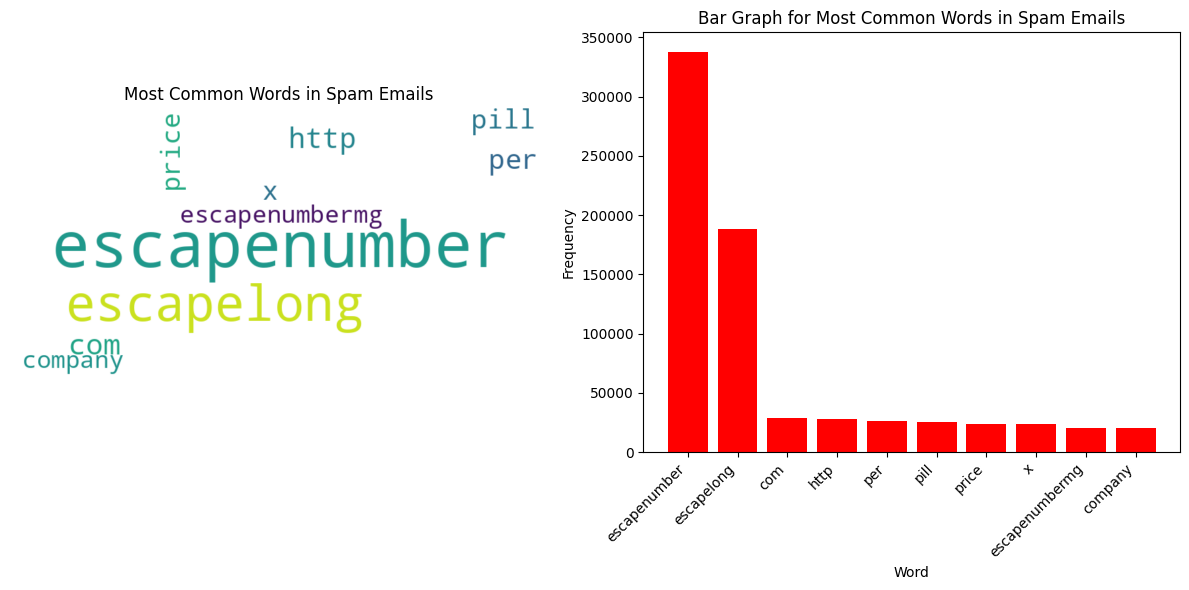

In [20]:
# generat word cloud for most common words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_spam_words))

# plot word cloud
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Spam Emails')

# plot bar graph
plt.subplot(1,2,2)
plt.title('Bar Graph for Most Common Words in Spam Emails')
plt.bar([word[0] for word in most_common_spam_words], [word[1] for word in most_common_spam_words], color='red')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
# ham emails cleaned text
ham_email_text = ' '.join(data[data['label'] == 0]['cleaned_text']).split()
ham_email_text


['computer',
 'connection',
 'cnn',
 'com',
 'wednesday',
 'escapenumber',
 'may',
 'escapenumber',
 'escapenumber',
 'escapenumber',
 'escapenumber',
 'pm',
 'edt',
 'report',
 'next',
 'generation',
 'toy',
 'read',
 'brain',
 'wave',
 'google',
 'expands',
 'personalization',
 'youtube',
 'win',
 'webby',
 'old',
 'fashioned',
 'rabbit',
 'ear',
 'laptop',
 'review',
 'next',
 'generation',
 'toy',
 'read',
 'brain',
 'wave',
 'startup',
 'company',
 'aim',
 'add',
 'realistic',
 'element',
 'video',
 'game',
 'using',
 'brain',
 'wave',
 'reading',
 'technology',
 'help',
 'game',
 'developer',
 'make',
 'gaming',
 'realistic',
 'http',
 'www',
 'cnn',
 'com',
 'escapenumber',
 'tech',
 'fun',
 'game',
 'escapenumber',
 'escapenumber',
 'mind',
 'reading',
 'toy',
 'ap',
 'index',
 'html',
 'google',
 'expands',
 'personalization',
 'google',
 'stepping',
 'effort',
 'allow',
 'user',
 'personalize',
 'search',
 'web',
 'http',
 'www',
 'cnn',
 'com',
 'escapenumber',
 'tech',
 'in

In [22]:
# count occourance for each word in ham
ham_word_counts = Counter(ham_email_text)
ham_word_counts

Counter({'computer': 2342,
         'connection': 2006,
         'cnn': 12711,
         'com': 40770,
         'wednesday': 4717,
         'escapenumber': 802460,
         'may': 21643,
         'pm': 16318,
         'edt': 879,
         'report': 7454,
         'next': 6440,
         'generation': 1345,
         'toy': 120,
         'read': 15980,
         'brain': 275,
         'wave': 253,
         'google': 1742,
         'expands': 85,
         'personalization': 6,
         'youtube': 291,
         'win': 1740,
         'webby': 46,
         'old': 3181,
         'fashioned': 47,
         'rabbit': 26,
         'ear': 129,
         'laptop': 2496,
         'review': 3741,
         'startup': 269,
         'company': 16696,
         'aim': 544,
         'add': 5836,
         'realistic': 108,
         'element': 1454,
         'video': 5229,
         'game': 1955,
         'using': 9697,
         'reading': 1292,
         'technology': 3417,
         'help': 33693,
         'devel

In [23]:
# find most common words in ham
most_common_ham_words = ham_word_counts.most_common(10)
most_common_ham_words

[('escapenumber', 802460),
 ('http', 63587),
 ('r', 54033),
 ('enron', 52858),
 ('c', 45460),
 ('org', 42564),
 ('com', 40770),
 ('escapelong', 39095),
 ('ect', 34745),
 ('list', 33808)]

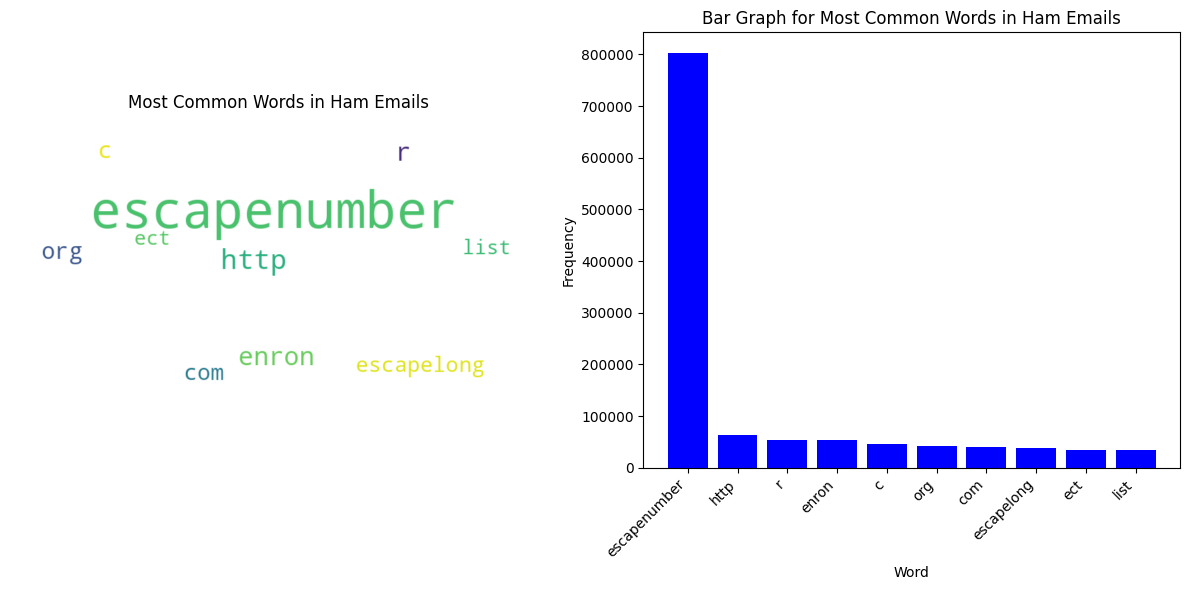

In [24]:
# word cloud for ham emails
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_ham_words))

# plot word cloud
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Ham Emails')

# bar plot graph
plt.subplot(1,2,2)
plt.title('Bar Graph for Most Common Words in Ham Emails')
plt.bar([word[0] for word in most_common_ham_words], [word[1] for word in most_common_ham_words], color='blue')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Vectorization

In [25]:
# data spliting and vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['cleaned_text']).toarray()
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Building the model

As we know Our Target variable is a classification type so to achieve this, we explore various machine learning models: Support Vector Machines (SVM), Random Forest, and Naive Bayes classifiers. These models learn from our preprocessed email data to distinguish between spam and legitimate messages. We evaluate each model’s performance using metrics like accuracy and precision. By comparing their performance, we determine the most effective model for accurately identifying spam emails. This process aids in enhancing email security by ensuring that our detection system effectively filters out unwanted messages, providing users with a safer and more efficient email experience.

In [27]:
# random forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
print(f'Accuracy: {accuracy_rf:.2f}')
print(f'Precision: {precision_rf:.2f}')
print(f'confusion matrix: {confusion_matrix(y_test, y_pred_rf)}')

Accuracy: 0.99
Precision: 0.98
confusion matrix: [[7803  135]
 [  92 8660]]


In [28]:
# naive base classifier
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
print(f'Accuracy: {accuracy_nb:.2f}')
print(f'Precision: {precision_nb:.2f}')
print(f'confusion matrix: {confusion_matrix(y_test, y_pred_nb)}')

Accuracy: 0.96
Precision: 0.96
confusion matrix: [[7604  334]
 [ 354 8398]]


In [31]:
# linear svc

svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc)
print(f'Accuracy: {accuracy_svc:.2f}')
print(f'Precision: {precision_svc:.2f}')
print(f'confusion matrix: {confusion_matrix(y_test, y_pred_svc)}')

Accuracy: 0.98
Precision: 0.98
confusion matrix: [[7762  176]
 [ 106 8646]]


In [32]:
#Predict new data with random forest
new_emails = ["Get a free iPhone now!",
    "Hey, how's it going?",
    "Congratulations! You've won a prize!",
    "Reminder: Meeting at 2 PM tomorrow."
]

# Convert new data into numerical vectors using the trained tfidf_vectorizer
new_X = tfidf.transform(new_emails)
new_X_dense = new_X.toarray()

# Use the trained random  model to make predictions
rf_predictions = rf.predict(new_X_dense)

# Print the predictions
for email, prediction in zip(new_emails, rf_predictions):
    if prediction == 1:
        print(f"'{email}' is predicted as spam.")
    else:
        print(f"'{email}' is predicted as ham.")

'Get a free iPhone now!' is predicted as spam.
'Hey, how's it going?' is predicted as spam.
'Congratulations! You've won a prize!' is predicted as spam.
'Reminder: Meeting at 2 PM tomorrow.' is predicted as ham.
